Maybe from switching models, but I got a wierd error that the trainer couldn't train.
I thought perhaps it was a Torch setting, hence below.
But it was to install `sudo apt-get install python3.11-dev`

# Copied because I think it's a good start

In [1]:
import os
# os.environ.update({
#     # "TORCH_COMPILE_DISABLE": "1",
#     # "PYTORCH_DISABLE_TRITON_INFERENCE": "1", 
#     # "TRITON_DISABLE_LINE_INFO": "1"
#     "TOKENIZERS_PARALLELISM": True
# })

In [2]:
from collections import Counter
import json
import sqlite3
import pandas as pd
from datasets import Dataset
from pathlib import Path
import logging
import re

import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from datetime import datetime
from typing import List
from enum import Enum
import spacy
import matplotlib.pyplot as plt

import shutil
import glob

/home/ksull18/code/iu-autonomous-fact-checker/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following is just a work in progress - but this config will help for building and testing I hope.

In [3]:
class FileConfig:
    __FullRunContext = """denotes using the complete dataset of just a smaller portion of it for testing."""
    FullRun = True

    __MiniRunContext = """denotes using a mini dataset for testing. If FullRun is True this is ignored."""
    MiniRun = False

    __ModelVersionContext = """To keep things in order, you may set model version here."""
    ModelVersion = "v0.1.0"

    ## NOTE: currently not in use for this file
    __Percentage = """If NOT a full run, what percentage of data do we use? (Think decimal values 0 < pc < 1)"""
    Percentage = 0.1
    
    __ToBuildContext = """Do we want to build another model or run without build for testing purposes."""
    ToBuild = True

    __CustomLossFnContext = """For certain cases with class imbalance we need a custom loss function."""
    CustomLossFn = False
    
    __ChunkOverlapContext = """For the vector store, chunks are 64 words with 8 word overlap."""
    ChunkOverlap = 8

    # Don't know why an option, it's basically required.
    UsePadding = True

    # BaseModelName = "bert-base-uncased" # Context too small
    # BaseModelName = "answerdotai/ModernBERT-base"
    BaseModelName = "distilbert-base-uncased" # all lowercase
    # I think ModernBert allows for 512 * 16 = 8192
    MaxTokens = 512
    Hardware = 'cuda' if torch.cuda.is_available() else 'cpu'

# class Labels(Enum)
LabelMap = Enum(
    'LabelMap', 
    [
        ('political', 0),
        ('other', 1),
        # ('NOT ENOUGH INFO', 2),
    ]
)
print(f"HARDWARE: {FileConfig.Hardware}")

HARDWARE: cuda


In [4]:
# FULL_RUN denotes using all the dataset or a small bit of it for testing the process
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Turned out the database was 52GB of Wikipedia articles, but the dataset fit OK in one file so chunking wasn't necessary...
Keeping the logic though.

## Loading Data

I've vectorized the evidence best I can so it matches the inputs it will receive.

In [5]:
processed_data_home = Path('.').resolve() / '.datasets'
dfpart = pd.read_parquet(processed_data_home / 'partial_full20250819.parquet')
dfpart.columns

Index(['pre_text', 'label'], dtype='object')

In [6]:
dfpart['label'].value_counts()

label
political    246186
other          6563
Name: count, dtype: int64

In [7]:
dfpart_other = dfpart[dfpart['label'] == 'other']
dfpart_pol = dfpart[dfpart['label'] == 'political']
dfpart_other_os = pd.concat([dfpart_other.sample(frac=1, ignore_index=True), dfpart_other.sample(frac=.2, ignore_index=True)])

lenother = len(dfpart_other_os)
print(lenother)

7876


In [8]:
dfpart_pol_s = dfpart_pol.sample(n=int(lenother), replace=False, ignore_index=True)

In [9]:
dfpart_s = pd.concat([dfpart_other_os, dfpart_pol_s])
print(dfpart_s.describe())

# x = dfpart_s.drop('label', axis=1)
# y = dfpart_s['label']

# x_train, x_test, y_train, y_test = train_test_split(
#     x, y,
#     test_size=0.1,
#     stratify=y,
#     random_state=42,
# )

# x_train, x_test, y_train, y_test = train_test_split(
#     x, y,
#     test_size=0.1,
#     stratify=y,
#     random_state=42,
# )

# -----------------------------------
# -----------------------------------
x_all = dfpart_s.drop('label', axis=1)
y_all = dfpart_s['label']
lth_all = len(x_all)
tenpc = int(len(x_all) * 0.1)
print(tenpc)
x_test, x_tmp, y_test, y_tmp = train_test_split(
    x_all, y_all,
    test_size=(len(x_all) - tenpc),
    stratify=y_all,
    random_state=42,
)
print(f"X Tmp: {len(x_tmp)}")
print(f"X test: {len(x_test)}")
print(f"Y Tmp: {len(y_tmp)}")
print(f"y Test: {len(y_test)}")
print(tenpc)

x_val, x_train, y_val, y_train = train_test_split(
    x_tmp, y_tmp,
    test_size=(len(x_tmp) - tenpc),
    stratify=y_tmp,
    random_state=42,
)
print(f"X Train: {len(x_train)}")
print(f"X Val: {len(x_val)}")
print(f"Y Tmp: {len(y_train)}")
print(f"y Test: {len(y_val)}")
# -----------------------------------
# -----------------------------------

# Train for training
pdft = x_train.copy()
pdft['label'] = y_train.values

# Dev for testing
pdfd = x_test.copy()
pdfd['label'] = y_test.values

# Validation for validation
pdfv = x_val.copy()
pdfv['label'] = y_val.values


# I don't have split data at moment. 
# pds = load_processed_fever(processed_data_home, 'fever_dev_chunk')
# pdfd = pd.DataFrame(pds)
pdft.head()

                                                 pre_text  label
count                                               15752  15752
unique                                              14168      2
top     Side by side comparison of the news. Comment o...  other
freq                                                   98   7876
1575
X Tmp: 14177
X test: 1575
Y Tmp: 14177
y Test: 1575
1575
X Train: 12602
X Val: 1575
Y Tmp: 12602
y Test: 1575


,pre_text,label
7204,"Vintage copy of ""The Politics of Rich and Poor...",political
5970,News found via Crowdpac - Social Network For P...,political
2793,Happy Mother s Day to all the mothers out ther...,other
1485,French President Macron heads to Algeria to re...,political
7408,Faultlines re-open as Tunisian president's sup...,political


In [10]:
print("Training Data")
print(pdft['label'].value_counts())
print(len(pdft))

Training Data
label
political    6301
other        6301
Name: count, dtype: int64
12602


In [11]:
print('Testing Data')
print(pdfd['label'].value_counts())
print(len(pdfd))

Testing Data
label
political    788
other        787
Name: count, dtype: int64
1575


In [12]:
print('Validation Data')
print(pdfv['label'].value_counts())
print(len(pdfv))

Validation Data
label
other        788
political    787
Name: count, dtype: int64
1575


In [13]:
# what is not enough data?
mask = pdft["label"] == "NOT ENOUGH INFO"
print(mask)
baddf = pdft[mask]

# could also go with iloc
for index, row in baddf.head(10).iterrows():
    print(f"{index + 1}.) {row['claim']}")
    print("Evidence:")
    for t in row['evidence']:
        print(f"  {t}")
    print("---"*10)

7204    False
5970    False
2793    False
1485    False
7408    False
        ...  
6016    False
1135    False
6710    False
5773    False
350     False
Name: label, Length: 12602, dtype: bool


# Model Training

Going to follow pretty close to how I trained the claim extractor / detector model.
Going to finetune BERT first I think as the context might not be big enough in DistilBERT for the evidence.

## Data Preparation

I saved the entire evidence in the 'vector_evidence' so not to lose something and need to recreate datasets... again.
However, now we must update our 'evidence' column here... 
Don't overwrite any files!

In [14]:
pdft.head()

,pre_text,label
7204,"Vintage copy of ""The Politics of Rich and Poor...",political
5970,News found via Crowdpac - Social Network For P...,political
2793,Happy Mother s Day to all the mothers out ther...,other
1485,French President Macron heads to Algeria to re...,political
7408,Faultlines re-open as Tunisian president's sup...,political


In [15]:
pdfd.head()

,pre_text,label
5829,"NEW YEAR, NEW #PHONE Save $15 on {{USERNAME}} ...",other
3501,Winning tickets from {{USERNAME}} to see {{USE...,other
2439,#starwars #riseofskywalker No spoiler reaction...,other
3624,"In 2022, let's normalize citing credible sourc...",political
4050,Successful second Halloween! Went to see Birds...,other


In [16]:
pdfv.head()

,pre_text,label
3639,August Alsina Releases ‘Entanglements’ Song Fe...,other
4832,I just earned the Beer of the World (Level 10...,other
6403,Family bids farewell to British journalist mur...,political
6134,All the #news that #funny to tell? from {{USER...,political
5528,UFC 251 Post-Fight Matchmaking: Jessica Andrad...,other


In [17]:
# Data Shuffle
for _ in range(3):
    pdft = pdft.sample(frac=1, replace=False, ignore_index=True)
    pdfd = pdfd.sample(frac=1, replace=False, ignore_index=True)
    pdfv = pdfv.sample(frac=1, replace=False, ignore_index=True)

## Loading and Setup with BERT

### Initialize Tokenizer and Model

In [18]:
# Loading tokenizer for this model
tokenizer = AutoTokenizer.from_pretrained(FileConfig.BaseModelName)
# dir(tokenizer)

In [19]:
# Ran into tokenization issue - All tensors in a batch should be same length
# Some were 100 and but one was 187.
# Use padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    FileConfig.BaseModelName, 
    num_labels=2,  # Either political or not
)
model.to(FileConfig.Hardware)

print(f"Model loaded: {FileConfig.BaseModelName}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Vocabulary size: 30522


### Tokenize Data

Unlike the claim_extractor model, which just had the claim and a label, this model has claims and evidence, and 3 labels. 
I believe our tokenizer must handle the proper combination.

In [21]:
# May need to update based on use case in future (If I copy this file for any other model)
def data_transform(text: str):
    """
    This will be used later when we need to actually use this model.
    """
    # Update for BERT Specific
    return f"[CLS] {text} [SEP]"
    # return f"CLAIM: {claim} EVIDENCE: {evidence_text}"


Loading tokenizer: distilbert-base-uncased
Analyzing 12602 texts...
Processed 1000 texts...
Processed 2000 texts...
Processed 3000 texts...
Processed 4000 texts...
Processed 5000 texts...
Processed 6000 texts...
Processed 7000 texts...
Processed 8000 texts...
Processed 9000 texts...
Processed 10000 texts...
Processed 11000 texts...
Processed 12000 texts...

TOKEN LENGTH STATISTICS
Total samples: 12,602
Average length: 51.8 tokens
Median length: 49.0 tokens
Standard deviation: 20.7
Min length: 9 tokens
Max length: 493 tokens

PERCENTILES:
25th percentile: 36.0 tokens
50th percentile: 49.0 tokens
75th percentile: 66.0 tokens
90th percentile: 78.0 tokens
95th percentile: 85.0 tokens
99th percentile: 97.0 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.0% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


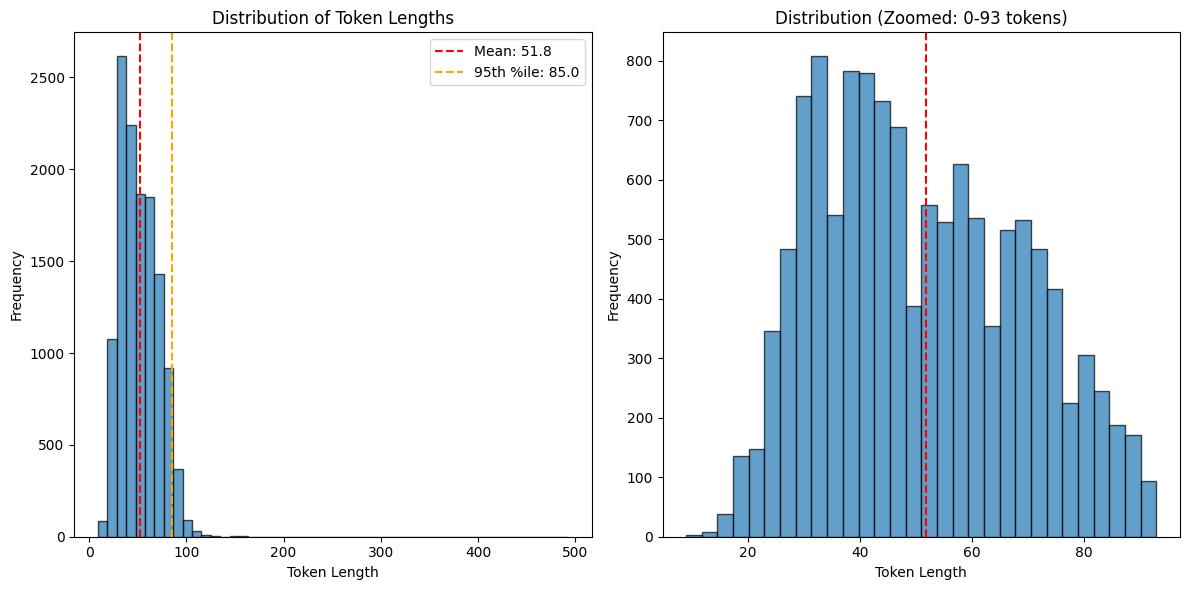

Loading tokenizer: distilbert-base-uncased
Analyzing 1575 texts...
Processed 1000 texts...

TOKEN LENGTH STATISTICS
Total samples: 1,575
Average length: 51.6 tokens
Median length: 49.0 tokens
Standard deviation: 19.3
Min length: 11 tokens
Max length: 150 tokens

PERCENTILES:
25th percentile: 36.0 tokens
50th percentile: 49.0 tokens
75th percentile: 66.0 tokens
90th percentile: 78.0 tokens
95th percentile: 85.0 tokens
99th percentile: 97.0 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.0% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


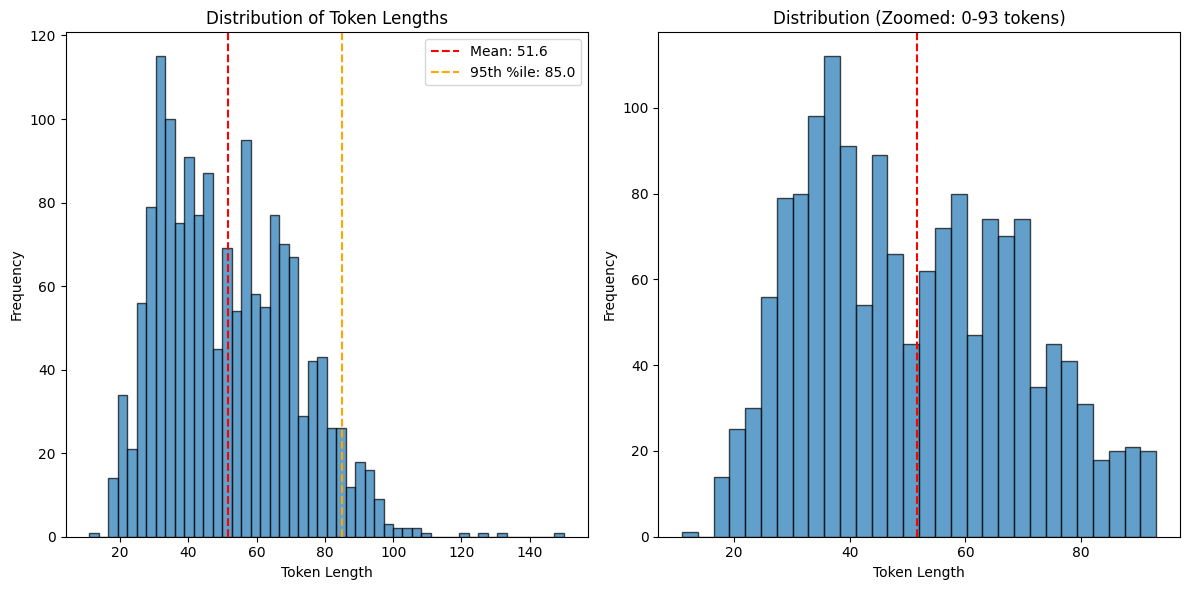

Loading tokenizer: distilbert-base-uncased
Analyzing 1575 texts...
Processed 1000 texts...

TOKEN LENGTH STATISTICS
Total samples: 1,575
Average length: 51.4 tokens
Median length: 48.0 tokens
Standard deviation: 20.7
Min length: 9 tokens
Max length: 365 tokens

PERCENTILES:
25th percentile: 36.0 tokens
50th percentile: 48.0 tokens
75th percentile: 65.0 tokens
90th percentile: 78.0 tokens
95th percentile: 85.0 tokens
99th percentile: 98.3 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.1% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


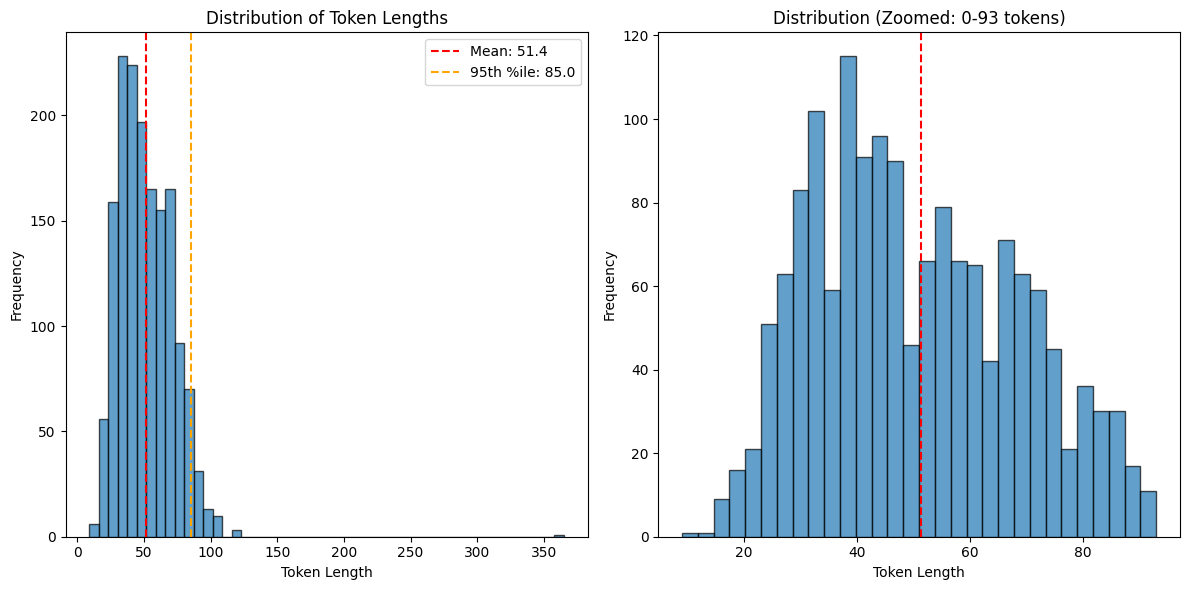

In [22]:
# Find good max token length...
def analyze_token_lengths(df, text_column='text', tokenizer_name='answerdotai/ModernBERT-base'):
    """
    Analyze token lengths in your dataset
    
    Args:
        df: pandas DataFrame
        text_column: name of column containing text
        tokenizer_name: HuggingFace tokenizer to use
    """
    
    # Load tokenizer
    print(f"Loading tokenizer: {tokenizer_name}")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    # Get all texts
    texts = df[text_column].tolist()
    print(f"Analyzing {len(texts)} texts...")
    
    # Tokenize without truncation to get true lengths
    token_lengths = []
    
    # Process in batches for efficiency
    batch_size = 100
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        tokenized = tokenizer(
            batch_texts, 
            truncation=False,  # Don't truncate - we want true lengths
            padding=False,     # Don't pad
            return_tensors=None
        )
        
        # Get lengths
        batch_lengths = [len(tokens) for tokens in tokenized['input_ids']]
        token_lengths.extend(batch_lengths)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)} texts...")
    
    # Calculate statistics
    token_lengths = np.array(token_lengths)
    
    stats = {
        'count': len(token_lengths),
        'mean': np.mean(token_lengths),
        'median': np.median(token_lengths),
        'std': np.std(token_lengths),
        'min': np.min(token_lengths),
        'max': np.max(token_lengths),
        '25th_percentile': np.percentile(token_lengths, 25),
        '50th_percentile': np.percentile(token_lengths, 50),
        '75th_percentile': np.percentile(token_lengths, 75),
        '90th_percentile': np.percentile(token_lengths, 90),
        '95th_percentile': np.percentile(token_lengths, 95),
        '99th_percentile': np.percentile(token_lengths, 99)
    }
    
    # Print results
    print("\n" + "="*50)
    print("TOKEN LENGTH STATISTICS")
    print("="*50)
    print(f"Total samples: {stats['count']:,}")
    print(f"Average length: {stats['mean']:.1f} tokens")
    print(f"Median length: {stats['median']:.1f} tokens")
    print(f"Standard deviation: {stats['std']:.1f}")
    print(f"Min length: {stats['min']} tokens")
    print(f"Max length: {stats['max']:,} tokens")
    print()
    print("PERCENTILES:")
    print(f"25th percentile: {stats['25th_percentile']:.1f} tokens")
    print(f"50th percentile: {stats['50th_percentile']:.1f} tokens")
    print(f"75th percentile: {stats['75th_percentile']:.1f} tokens")
    print(f"90th percentile: {stats['90th_percentile']:.1f} tokens")
    print(f"95th percentile: {stats['95th_percentile']:.1f} tokens")
    print(f"99th percentile: {stats['99th_percentile']:.1f} tokens")
    
    # Recommendations based on percentiles
    print("\n" + "="*50)
    print("RECOMMENDATIONS:")
    print("="*50)
    
    if stats['95th_percentile'] <= 256:
        print("  Recommended max_length: 256 (covers 95% of data)")
    elif stats['95th_percentile'] <= 512:
        print("  Recommended max_length: 512 (covers 95% of data)")
    elif stats['90th_percentile'] <= 512:
        print("️!  Consider max_length: 512 (covers 90% of data)")
        print(f"   Note: {100-90:.1f}% of samples will be truncated")
    elif stats['95th_percentile'] <= 1024:
        print("  Recommended max_length: 1024 (covers 95% of data)")
    else:
        print(f"  Consider max_length: {int(stats['95th_percentile'])} (covers 95% of data)")
        print("   Or use 1024 if you want faster training with some truncation")
    
    print(f"\nData truncated at different max_lengths:")
    for max_len in [256, 512, 768, 1024, 2048]:
        pct_truncated = (token_lengths > max_len).mean() * 100
        print(f"  max_length={max_len}: {pct_truncated:.1f}% truncated")
    
    # Create histogram
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Lengths')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    plt.axvline(stats['95th_percentile'], color='orange', linestyle='--', label=f'95th %ile: {stats["95th_percentile"]:.1f}')
    plt.legend()
    
    # Zoomed in view (up to 95th percentile)
    plt.subplot(1, 2, 2)
    zoom_limit = min(int(stats['95th_percentile'] * 1.1), stats['max'])
    zoom_data = token_lengths[token_lengths <= zoom_limit]
    plt.hist(zoom_data, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution (Zoomed: 0-{zoom_limit} tokens)')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    
    plt.tight_layout()
    plt.show()
    
    return stats, token_lengths

pdft.head(2)
pdft['input'] = pdft.apply(lambda x: data_transform(x['pre_text']), axis=1)
pdfd['input'] = pdfd.apply(lambda x: data_transform(x['pre_text']), axis=1)
pdfv['input'] = pdfv.apply(lambda x: data_transform(x['pre_text']), axis=1)

statst, token_lengthst = analyze_token_lengths(pdft, text_column='input', tokenizer_name=FileConfig.BaseModelName)
statsd, token_lengthsd = analyze_token_lengths(pdfd, text_column='input', tokenizer_name=FileConfig.BaseModelName)
statsv, token_lengthsv = analyze_token_lengths(pdfv, text_column='input', tokenizer_name=FileConfig.BaseModelName)

> Perhaps a point of improvement - better input and separation of claims and evidence. 

In [23]:
max_token_len = getattr(tokenizer, 'model_max_length', 512)
max_token_len = min(FileConfig.MaxTokens, max_token_len)
print(max_token_len)
# 512 is returned for distilbert which is more than plenty for these text inputs

512


In [24]:
def tokenize_fn(dataset):
    # Combine claim and evidence into single text input
    texts = [t for t in dataset['input']]
    # TODO: doesn't the other file also use input...? 
    # for claim, evidence in zip(dataset['claim'], dataset['evidence']):
    #     combined_text = data_transform(claim, evidence)
    #     texts.append(combined_text)
    
    # Token Length calculated outside - impure but only once

    model_inputs = tokenizer(
        texts,
        truncation=True,
        padding=FileConfig.UsePadding,
        max_length=max_token_len,
    )

    label_map = {"political": 0, "other": 1}
    model_inputs["label"] = [label_map[label] for label in dataset['label']]

    return model_inputs

#### Data Debugging

The training is not working because it says the labels are a list...

In [37]:
# Checking the structure of your pandas data before conversion
if False:
    print("Sample rows from pdft:")
    print(pdft[['claim', 'evidence', 'label']].head(2))
    print("\nData types:")
    print(pdft[['claim', 'evidence', 'label']].dtypes)
    print("\nSample evidence type:")
    print(type(pdft['evidence'].iloc[0]))
    print("Sample evidence content:")
    print(pdft['evidence'].iloc[0])
    print("\nSample label type:")
    print(type(pdft['label'].iloc[0]))
    pdft[['claim', 'evidence', 'label']].head(2)

### Constant...

LABELS is for computing class weights later...

In [38]:
LABELS = pdft['label'].values

In [39]:
min(pdft['label'].value_counts())

6301

[This StackOverflow post](https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows) lists several ways to shuffle a dataframe. 
Pandas has the builtin `df = df.sample(frac=1).reset_index(drop=True)` which apparently reassigns but does not recreate.
SciKit Learn also has a "shuffle" method but that might require resetting indexes.
There are then seemingly countless ways after that as well...

Side note on sample - it now has an 'ignore_index' param to help with that reset issue.

In [40]:
# Convert pandas DataFrames to 🤗 Dataset objects
if FileConfig.FullRun:
    print("Full Run!")
    dst = Dataset.from_pandas(pdft[['input', 'label']])
    dsv = Dataset.from_pandas(pdfd[['input', 'label']])
elif FileConfig.MiniRun:
    print("Mini Run!")
    # mini-datasets for running into issues... 😖
    # should probably go in the data processing section
    # there's probably an easier way...
    training_mini = pd.concat([
        pdft[pdft['label'] == 'SUPPORTS'].sample(n=100, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'REFUTES'].sample(n=100, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'NOT ENOUGH INFO'].sample(n=100, replace=False, ignore_index=True),
    ])

    val_mini = pd.concat([
        pdfd[pdfd['label'] == 'SUPPORTS'].sample(n=20, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'REFUTES'].sample(n=20, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'NOT ENOUGH INFO'].sample(n=20, replace=False, ignore_index=True),
    ])

    ## Shuffle data
    for _ in range(5):
        training_mini = training_mini.sample(frac=1, replace=False, ignore_index=True)
        val_mini = val_mini.sample(frac=1, replace=False, ignore_index=True)

    print(training_mini['label'].value_counts())
    print(val_mini['label'].value_counts())
    dst = Dataset.from_pandas(training_mini[['claim', 'evidence', 'label']])
    dsv = Dataset.from_pandas(val_mini[['claim', 'evidence', 'label']])

    ## REDO Labels - shouldn't be too different
    LABLES = training_mini['label'].values
else:
    # This is not ready yet
    pc = FileConfig.Percentage
    print(f"Partial Run of {pc:.02%}")


    # NEW STRATEGY
    numr = min(pdft['label'].value_counts()) * 2
    training_mini = pd.concat([
        pdft[pdft['label'] == 'SUPPORTS'].sample(n=numr, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'REFUTES'].sample(n=numr, replace=False, ignore_index=True),
        # allowing replacement here.
        pdft[pdft['label'] == 'NOT ENOUGH INFO'].sample(n=numr, replace=True, ignore_index=True),
    ])

    val_mini = pd.concat([
        pdfd[pdfd['label'] == 'SUPPORTS'].sample(frac=1, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'REFUTES'].sample(frac=1, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'NOT ENOUGH INFO'].sample(frac=1, replace=False, ignore_index=True),
    ])

    # Shuffling / Randomizing data
    for _ in range(5):
        training_mini = training_mini.sample(frac=1, replace=False, ignore_index=True)
        val_mini = val_mini.sample(frac=1, replace=False, ignore_index=True)

    print(training_mini['label'].value_counts())
    print(val_mini['label'].value_counts())
    dst = Dataset.from_pandas(training_mini[['claim', 'evidence', 'label']])
    dsv = Dataset.from_pandas(val_mini[['claim', 'evidence', 'label']])

    ## REDO Labels - shouldn't be too different
    LABLES = training_mini['label'].values

# Apply tokenization
train_dataset = dst.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dst.column_names,
)
val_dataset = dsv.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dsv.column_names,
)

print("Data tokenized successfully!")

Full Run!


Map: 100%|██████████| 1575/1575 [00:00<00:00, 12896.48 examples/s]

Data tokenized successfully!


In [43]:
train_dataset.description

''

In [44]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


The below helped me find a mismatch in data-types between the dataset I thought I was making and what was really created...
which the training did not like.

In [45]:
# Check the dataset structure after conversion from pandas
if False:
    print("Dataset columns:", dst.column_names)
    print("Dataset features:", dst.features)
    print("First example:")
    try:
        print(dst[0])
    except Exception as e:
        print(f"Error accessing first example: {e}")

    # Check if there are any problematic column names or types
    for col in dst.column_names:
        print(f"Column '{col}' type: {type(dst[col])}")
        try:
            print(f"First value: {dst[col][0]}")
            print(f"First value type: {type(dst[col][0])}")
        except Exception as e:
            print(f"Error accessing column '{col}': {e}")
        print("---")

    print("="*25)

    print("Dataset columns:", train_dataset.column_names)
    print("Dataset features:", train_dataset.features)
    print("First example:")
    try:
        print(train_dataset[0])
    except Exception as e:
        print(f"Error accessing first example: {e}")

    # Check if there are any problematic column names or types
    for col in train_dataset.column_names:
        print(f"Column '{col}' type: {type(train_dataset[col])}")
        try:
            print(f"First value: {train_dataset[col][0]}")
            print(f"First value type: {type(train_dataset[col][0])}")
        except Exception as e:
            print(f"Error accessing column '{col}': {e}")
        print("---")

## Fine-Tune the Model

We are doing **transfer learning** with **fine-tuning**. 
BERT was pre-trained to understand language - Thank you!
We fine-tuning the model for a specific task - claim vs opinion here.
The technique = Supervised learning with backpropagation

Deep dive: BERT has millions of weights to understand language. We are adjusting these to suit our classification task. Only our final classification layer is learning from scratch. The rest of BERT is merely adapting instead of being completely retrained. 
BERT (I think) expects a "[MASK]" token to predict values. 
By fine-tuning, we add a layer like: `input text -> BERT Encoder -> Classification Head -> [Claim, Opinion] probabilities`.

### Defining Training Arguments

> I am taking most of this from the claim_extractor I made previously

In [47]:
# Set up directories for saving
datenow = datetime.now()
timestamp = datenow.strftime("%Y%m%d%H%M%S")

# TODO: Give model name at top
move_path = Path().cwd() / "trainingresults" / f'hide-distilbert_{timestamp}'
out_path = Path().cwd() / "trainingresults" / "latest"
metatdata_file_path = out_path / "metadata.json"

# Below is the logic for moving previous versions
if FileConfig.ToBuild:
    if metatdata_file_path.exists():
        # A model exists in latest already - move to it's timestamp

        try:
            with open(metatdata_file_path, 'r') as file:
                tmp = json.load(file)
                str_path = tmp.get('path', None)
                assert str_path is not None
                ts_path = Path(str_path)
                # Moving the old model into its timestamp directory
                out_path.rename(ts_path)
        except Exception as e:
            logger.warning(e)
            # suggests something in directory didn't finish and should probably be deleted?
        assert not out_path.exists()

    ## Open cannot make the directories after I rename them...
    out_path.mkdir(parents=True, exist_ok=True)

    with open(out_path / "metadata.json", 'w') as file:
        json.dump({"path": str(move_path), "foundation": FileConfig.BaseModelName, 'timestamp': datenow.isoformat(), "version": FileConfig.ModelVersion}, file, indent=2)

In [48]:
## OLD
# training_args = TrainingArguments(
#     output_dir=out_path, # Working directory during training for logs and checkpoints.
#     num_train_epochs=3,              # Start with 3, adjust based on results
#     ## batch size of 16 gets to 5.6/6GB of RTX 3060
#     per_device_train_batch_size=8,  # Reduce if memory issues
#     per_device_eval_batch_size=16,
#     warmup_steps=500, # gradually increase learning rate over 1000 steps | prevents huge descrutive changes early on
#     weight_decay=0.01, # Very mild 1% to prevent memorizing training data exactly. 
#     logging_dir='./logs',
#     ## had set to 10 which is a lot of overhead
#     logging_steps=20,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     dataloader_pin_memory=False, # can help with GPU transfer speed
#     fp16=True, # mixed precision can speedup training if supported
#     dataloader_num_workers=4, # parallel data loading
# )

# New'ish
# I increased Epochs and changed the saving and eval strategies to Steps
training_args = TrainingArguments(
    output_dir=out_path, # Working directory during training for logs and checkpoints.
    num_train_epochs=3 if FileConfig.FullRun else 1,              # Start with 3, adjust based on results
    ## batch size of 16 gets to 5.6/6GB of RTX 3060
    per_device_train_batch_size=4,  # Reduce if memory issues
    per_device_eval_batch_size=4,
    warmup_steps=1000 if FileConfig.FullRun else 50, # gradually increase learning rate over 1000 steps | prevents huge descrutive changes early on
    weight_decay=0.01, # Very mild 1% to prevent memorizing training data exactly. 
    logging_dir='./logs',
    ## had set to 10 which is a lot of overhead
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500 if FileConfig.FullRun else 100,
    save_strategy="steps",
    save_steps=500 if FileConfig.FullRun else 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Changing for balanced data
    greater_is_better=True, # updated
    dataloader_pin_memory=False, # can help with GPU transfer speed
    fp16=True, # mixed precision can speedup training if supported
    dataloader_num_workers=4, # parallel data loading
)

### Define Evaluation Metrics

SciKit Learn has some handy prebuilt functions.

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Custome Weights

The data is quite unbalanced.
There is a total of 48,205 entries:
- supports = 31,811
- refutes = 14,610
- na = 1,784

Rebalancing to the tiny amount is not desireable.
The `Trainer` can take in a loss function. The signature is just 'Callable' so inside the class it takes in `(outputs, labels, num_items_in_batch)`.

There are several loss functions to consider:
- 


[SciKit-Learn's `compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function follows the inverse frequency approach.

In [26]:
for I,J in enumerate(LabelMap):
    print(I)
    print(str(J))


0
LabelMap.political
1
LabelMap.other


In [56]:
def create_weights(labels):
    unique_labels = np.unique(labels)
    weights_balanced = compute_class_weight('balanced', classes=unique_labels, y=labels)
    weight_tensor = torch.zeros(3)

    for index, en in enumerate(LabelMap):
        label_inx = np.where(unique_labels == en.name)[0][0]
        weight_tensor[index] = weights_balanced[label_inx]
    
    return weight_tensor

class_weights = create_weights(LABELS)
class_weights = class_weights.to(model.device)
print(class_weights)

# This needs work, I don't think weights should change nor be calucated during each batch...
def custom_weighted_loss_fn(outputs, labels, num_items_in_batch=None):
    logits = outputs.logits # Model's raw predictions [batch_size, 3]

    # Method 1: Balanced - Inverse Frequency
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    # This is impure function for now
    loss = loss_fn(logits, labels)
    return loss
    

tensor([1., 1., 0.], device='cuda:0')


### Initialize and Train!

In [57]:
print(len(train_dataset))
print(len(val_dataset))

12602
1575


Randomly getting error: trying `sudo apt-get install build-essential`
NO
did `sudo apt-get install python3.11-dev`

Seems working now...

In [58]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator if FileConfig.UsePadding else None,
    compute_metrics=compute_metrics,
    compute_loss_func=custom_weighted_loss_fn if FileConfig.CustomLossFn else None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # if no improvements
    optimizers=(None, None), # Letting Trainer handle optimizer
)

# Start training
print("Starting training...")
if FileConfig.ToBuild:
    trainer.train()
    # Save the model
    trainer.save_model(out_path) # Where to save model weights and config
    tokenizer.save_pretrained(out_path) # for tokenizer stuff
    print("Model saved!")
    print("Cleaning up Checkpoints...")
    checkpoint_dirs = glob.glob(f"{out_path}/checkpoint-*")
    for checkpoint_dir in checkpoint_dirs:
        shutil.rmtree(checkpoint_dir)
    print("Clean up complete!")

Starting training...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.122900,0.034819,0.993651,0.993651,0.993702,0.993651
1000,0.006000,0.039693,0.992381,0.992381,0.992432,0.992381
1500,0.062400,0.055382,0.992381,0.992381,0.992495,0.992381
2000,0.000300,0.089640,0.987937,0.987935,0.988221,0.987937


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Model saved!
Cleaning up Checkpoints...
Clean up complete!


## Test the Model

This is kind of the manual process I suppose for the time being.

### Loading Model

Loading from hugging face consumes too much VRAM

In [27]:
class TextClassifier:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        # Ensure token length
        self.tokenizer.model_max_length = FileConfig.MaxTokens
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map=FileConfig.Hardware,
        )
        self.model.eval()
    
    def __call__(self, text):
        # To not track gradients to save memory - don't need back propagation
        with torch.no_grad():
            inputs = self.tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True,
                # max_length=FileConfig.MaxTokens, 
                padding=True
            )
            inputs = {k: v.to(FileConfig.Hardware) for k, v in inputs.items()}
            outputs = self.model(**inputs)
            
            # Format like pipeline output
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_id = torch.argmax(probs, dim=-1).item()
            
            # Same as Hugging Face
            return [{
                'label': self.model.config.id2label[pred_id],
                'score': probs[0][pred_id].item()
            }]


In [29]:
print("\n")
# Load your fine-tuned model
# TODO: UPDATE!!!
out_path = Path('.').resolve() / "trainingresults" / "latest"
if False:
    the_judge = pipeline(
        task="text-classification",
        model=str(out_path),
        tokenizer=str(out_path),
        device=FileConfig.Hardware,
        # For memory:
        torch_dtype=torch.float16,
        model_kwargs={"torch_dtype": torch.float16},
        tokenizer_kwargs={"max_length": 1012, "truncation": True}  # Force this length
    )
else:
    the_detective = TextClassifier(str(out_path))

Making up some claims and support for manual testing

In [30]:
fake_test_data = [
    # SUPPORTS - 4 claims
    {
        "id": 1,
        "claim": "The 2024 US presidential election had the highest voter turnout in history.",
        "evidence": [
            "According to the Federal Election Commission, approximately 158 million Americans voted in the 2024 presidential election. This surpassed the previous record of 155 million voters set in 2020. Election officials reported that turnout reached 66.8% of eligible voters, marking a new milestone in American electoral participation.",
        ],
        "label": "SUPPORTS",
        "context": "Short and factual about voter turnout."
    },
    {
        "id": 2, 
        "claim": "Social Security benefits increased by 3.2% in 2024.",
        "evidence": [
            "The Social Security Administration announced a 3.2% cost-of-living adjustment for 2024 benefits. This increase affects over 67 million Social Security beneficiaries and 7 million SSI recipients. The adjustment was based on the Consumer Price Index data from the third quarter of 2023.",
        ],
        "label": "SUPPORTS",
        "context": "Matching percentages."
    },
    {
        "id": 3,
        "claim": "The federal minimum wage in America is $7.25 per hour.",
        "evidence": [
            "The federal minimum wage has remained at $7.25 per hour since July 2009, when it was last increased under the Fair Minimum Wage Act. While many states have implemented higher minimum wages, the federal rate serves as the baseline for all states. Congressional attempts to raise the federal minimum wage to $15 per hour have stalled in recent legislative sessions.",
        ],
        "label": "SUPPORTS",
        "context": "Simple fact about minimum wage."
    },
    {
        "id": 4,
        "claim": "Medicare covers prescription drug costs for seniors.",
        "evidence": [
            "Medicare Part D provides prescription drug coverage for Medicare beneficiaries, covering approximately 63 million seniors and disabled individuals. The program was established in 2006 and helps reduce out-of-pocket prescription costs. Recent legislation has also capped annual prescription drug costs at $2,000 starting in 2025 for Medicare recipients.",
        ],
        "label": "SUPPORTS",
        "context": "More evidence for slightly more vague claim."
    },
    # REFUTES - 4 claims  
    {
        "id": 5,
        "claim": "The US Constitution requires congressional approval for all military deployments overseas.",
        "evidence": [
            "The Constitution grants Congress the power to declare war, but does not require congressional approval for all military actions. The President, as Commander in Chief, has authority to deploy troops for limited periods without congressional authorization. The War Powers Resolution of 1973 requires congressional approval only for deployments lasting more than 60 days.",
        ],
        "label": "REFUTES",
        "context": "A constitutional misconception."
    },
    {
        "id": 6,
        "claim": "Climate change legislation was passed by Congress in 2023 with bipartisan support.",
        "evidence": [
            "No major climate change legislation received bipartisan support in Congress during 2023. The Inflation Reduction Act, which included climate provisions, was passed in 2022 with only Democratic votes. Several climate-related bills were introduced in 2023 but failed to advance due to partisan disagreements over implementation and funding mechanisms.",
        ],
        "label": "REFUTES",
        "context": "A false bipartisan claim about climate legislation."
    },
    {
        "id": 7,
        "claim": "The federal deficit decreased by 50% in 2024.",
        "evidence": [
            "The Congressional Budget Office reported that the federal deficit increased by approximately 8% in fiscal year 2024, reaching $1.9 trillion. This represents a significant increase from the previous year's deficit of $1.7 trillion. Rising interest payments on national debt and increased government spending contributed to the larger deficit.",
        ],
        "label": "REFUTES",
        "context": "A favourite for some, incorrect percentages."
    },
    {
        "id": 8,
        "claim": "All Supreme Court justices must be confirmed by a two-thirds majority in the Senate.",
        "evidence": [
            "Supreme Court nominees require only a simple majority vote for confirmation in the Senate, not a two-thirds majority. This threshold was established by Senate rules and precedent. The confirmation process involves Senate Judiciary Committee hearings followed by a full Senate vote, where 51 votes are sufficient for confirmation.",
        ],
        "label": "REFUTES",
        "context": "Incorrect claim about voting threshold."
    },
    # NOT ENOUGH INFO - 2 claims
    {
        "id": 9,
        "claim": "The new infrastructure bill will create 500,000 jobs in rural communities specifically.",
        "evidence": [
            "The Infrastructure Investment and Jobs Act allocated $1.2 trillion for various infrastructure projects across the United States. The legislation includes funding for roads, bridges, broadband expansion, and water systems. Economic analysts project the bill will create millions of jobs nationwide over the next decade, with significant benefits expected for both urban and rural areas.",
        ],
        "label": "NOT ENOUGH INFO",
        "context": "Evidence is about the project but without the supporting figures."
    },
    {
        "id": 10,
        "claim": "Congressional approval ratings reached their lowest point since 1974 last month.",
        "evidence": [
            "Recent polling shows Congress has historically low approval ratings, with multiple surveys indicating public dissatisfaction with legislative performance. Gallup polling has tracked congressional approval since the 1970s, showing significant fluctuations over the decades. Political polarization and gridlock have contributed to declining public confidence in the institution.",
        ],
        "label": "NOT ENOUGH INFO",
        "context": "Evidence does not specify exact timeframe nor comparison to 1974."
    },
    {
        "id": 11,
        "claim": "Trump and Putin are meeting in Alaska to talk about ending the war in Ukraine.",
        "evidence": [],
        "label": "NOT ENOUGH INFO",
        "context": "Very recent news as of today, withholding evidence even though it does techincally exist."
    }
]



Above: I was going to do the multiple sentences but when we pass data into the model I zip them up anyways so... it's half done for now.

In [31]:
# Create DataFrame and Dataset
def create_fake_dataset():
    """Create fake dataset for testing judge model"""
    df = pd.DataFrame(fake_test_data)
    
    print("Test Dataset Summary:")
    print(f"Total samples: {len(df)}")
    print("\nLabel Distribution:")
    label_counts = df['label'].value_counts()
    for label, count in label_counts.items():
        print(f"{label}: {count}")
    
    print("\nClaim Length Statistics:")
    df['claim_length'] = df['claim'].str.len()
    print(f"Average claim length: {df['claim_length'].mean():.0f} characters")
    print(f"Shortest claim: {df['claim_length'].min()} characters")
    print(f"Longest claim: {df['claim_length'].max()} characters")
    
    return Dataset.from_pandas(df)

# Create the dataset
test_dataset = create_fake_dataset()

Test Dataset Summary:
Total samples: 11

Label Distribution:
SUPPORTS: 4
REFUTES: 4
NOT ENOUGH INFO: 3

Claim Length Statistics:
Average claim length: 71 characters
Shortest claim: 45 characters
Longest claim: 90 characters


In [32]:
# for each test_case
for tc in test_dataset:
    print(f"TEST CASE: {tc['id']:02}")
    print(f"Claim: {tc['claim']}")
    print(f"Evidence: ")
    for x in [y for y in tc['evidence']]:
        print(f"  {x}")
    expected = tc['label']
    print(f"Label: {expected}")
    print(f"ABOUT: {tc['context']}")
    fixed = data_transform(tc['claim'], tc['evidence'])
    result_list = the_judge(fixed)
    result = result_list[0]
    print("RESULT:", json.dumps(result, indent=2))
    actual = result.get('label')
    if "0" in actual:
        actual = "SUPPORTS"
    elif "1" in actual:
        actual = "REFUTES"
    elif "2" in actual:
        actual = "NOT ENOUGH INFO"
    else:
        actual = "ERROR - WHAT?!?"
    print()
    correct = actual == expected
    if correct:
        print(f"✅ PREDICTED: {actual} | ACTUAL: {tc['label']}")
    else:
        print(f"❌ PREDICTED: {actual} | ACTUAL: {tc['label']}")
    print()

TEST CASE: 01
Claim: The 2024 US presidential election had the highest voter turnout in history.
Evidence: 
  According to the Federal Election Commission, approximately 158 million Americans voted in the 2024 presidential election. This surpassed the previous record of 155 million voters set in 2020. Election officials reported that turnout reached 66.8% of eligible voters, marking a new milestone in American electoral participation.
Label: SUPPORTS
ABOUT: Short and factual about voter turnout.


TypeError: data_transform() takes 1 positional argument but 2 were given

I know the validation data shouldn't be used, but just checking here for fun...

In [33]:
t_preds = []
t_labels = []

# I've created pdfv - never seen before.

if not FileConfig.FullRun:
    print('Minifying Validation Dataset')
    min_n = min(pdfd['label'].value_counts())
    min_n = 100
    pdfv = pd.concat([
            pdfv[pdfv['label'] == 'SUPPORTS'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'REFUTES'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'NOT ENOUGH INFO'].sample(n=min_n, replace=False, ignore_index=True),
        ])

print('Validation Data')
print(pdfv['label'].value_counts())

for _, row in pdfv.iterrows():
    result_list = the_detective(row['input'])
    result = result_list[0]
    actual = result.get('label')
    expected = row['label']
    if "0" in actual:
        actual = "political"
    elif "1" in actual:
        actual = "other"
    else:
        actual = "ERROR - WHAT?!?"
    t_preds.append(actual)
    t_labels.append(expected)

def compute_metrics_simple(predicted_values: List[str], actual_values: List[str]):
    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_values, predicted_values, average='weighted'
    )
    accuracy = accuracy_score(actual_values, predicted_values)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
test_results = compute_metrics_simple(t_preds, t_labels)
print(json.dumps(test_results, indent=2))

Validation Data
label
other        788
political    787
Name: count, dtype: int64
{
  "accuracy": 0.9911111111111112,
  "f1": 0.9911105520741168,
  "precision": 0.9912250896057349,
  "recall": 0.9911111111111112
}


In [34]:
print(pdfv['label'].value_counts())
print()
print(len(t_preds))
print()
mycounts = {}
for exp, act in zip(t_preds, t_labels):
    try:
        mycounts[exp][act] += 1
    except:
        one = mycounts.get(exp)
        if one is None:
            mycounts[exp] = {}
        mycounts[exp][act] = 1

print(json.dumps(mycounts, indent=2))

label
other        788
political    787
Name: count, dtype: int64

1575

{
  "political": {
    "political": 774,
    "other": 1
  },
  "other": {
    "other": 787,
    "political": 13
  }
}


In [35]:
cnt = 0
for i, r in pdfv.iterrows():
    print(r['input'])
    cnt += 1
    if cnt > 5:
        break

[CLS] I really hope I live to see a {{USERNAME}} Presidency. I love that man so much #Politics 🇺🇸 [SEP]
[CLS] ️Michael Owen s Premier League accumulator for today.  See what {{USERNAME}} has predicted will happen in the final matches today.  ⭐️Odds - 13/2. £5 bet wins £37.50 Betslip link included  Read his tips > {{URL}} #PremierLeague [SEP]
[CLS] im listening to watermelon sugar n i got goosebumps...LITERAL goosebumps. ur amazing. i love you. {{USERNAME}} [SEP]
[CLS]  {{URL}} 5 man down! I repeat 5 man down! Slow and steady wins the fight, but dont do what these guys did. Dont let someone push up stairs and take you down! #EscapefromTarkov {{USERNAME}} #twitch [SEP]
[CLS] Xbox Battle Predicts the 49ers to Win the Big Game as {{USERNAME}} Defeats {{USERNAME}} in {{USERNAME}} 20 Preview of Sunday’s Showdown!  #SBLIV {{URL}} [SEP]
[CLS] #1 Inspirational Station On The Internet Ver na Jones {{USERNAME}} - Uncoditional Promo - Visit: {{URL}} Listen online at {{URL}} [SEP]
